In [16]:
from fastai.tabular import * 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# This notebook uses FastAI's tabular library to apply deep learning techniques to this tabualr data set. We have defined our target varaible, 'class', to be Over or Under 180pts. 

# The model (summarized that the bottom of the notebook)  first encodes the categorical varaibles and then applies two layers of batch normalization, linear, and RELU activation followed by an output linear binary layer

In [17]:
path = './'
df = pd.read_csv(path+'nbafull.csv')
df.head()

,date,start_time,vis_team,home_team,vis_points,home_points,ot,attendance,home_initial,vis_initial,...,hp1,hp2,hp3,hp4,hp5,vis_city,home_city,home_state,home_temp,travel_miles
0,2019-10-22,20:00:00,New Orleans Pelicans,Toronto Raptors,122,130,1,20787,TOR,NOP,...,Kyle Lowry,Fred VanVleet,Pascal Siakam,OG Anunoby,Marc Gasol,New Orleans,Toronto,ON,57.10,1113.2
1,2019-10-22,22:30:00,Los Angeles Lakers,Los Angeles Clippers,102,112,0,19068,LAC,LAL,...,Kawhi Leonard,Patrick Beverley,Landry Shamet,Patrick Patterson,Ivica Zubac,Los Angeles,Los Angeles,CA,76.54,0.0
2,2019-10-23,19:00:00,Chicago Bulls,Charlotte Hornets,125,126,0,15424,CHO,CHI,...,P.J. Washington,Cody Zeller,Dwayne Bacon,Miles Bridges,Terry Rozier,Chicago,Charlotte,NC,57.13,587.1
3,2019-10-23,19:00:00,Detroit Pistons,Indiana Pacers,119,110,0,17923,IND,DET,...,Myles Turner,Malcolm Brogdon,Domantas Sabonis,T.J. Warren,Jeremy Lamb,Detroit,Indianapolis,IA,42.54,488.3
4,2019-10-23,19:00:00,Cleveland Cavaliers,Orlando Magic,85,94,0,18846,ORL,CLE,...,Nikola Vučević,Aaron Gordon,Evan Fournier,D.J. Augustin,Jonathan Isaac,Cleveland,Orlando,FL,76.45,893.8


In [18]:
df.columns

Index(['date', 'start_time', 'vis_team', 'home_team', 'vis_points',
       'home_points', 'ot', 'attendance', 'home_initial', 'vis_initial',
       'home_players', 'home_bench', 'vis_players', 'vis_bench', 'referees',
       'score_starter_home', 'score_bench_home', 'score_starter_vis',
       'score_bench_vis', 'recovery_time', 'perform', 'def_perf_home',
       'off_perf_home', 'def_perf_vis', 'off_perf_vis', 'total_score', 'class',
       'frac_season', 'day_hour', 'ref1', 'ref2', 'ref3', 'vp1', 'vp2', 'vp3',
       'vp4', 'vp5', 'hp1', 'hp2', 'hp3', 'hp4', 'hp5', 'vis_city',
       'home_city', 'home_state', 'home_temp', 'travel_miles'],
      dtype='object')

In [19]:
df = df.drop(columns=['date', 'start_time','vis_points','home_points', 'ot','home_players', 'home_bench',
                 'vis_players', 'vis_bench', 'referees','total_score',
                'vis_city','home_city', 'home_state', 'vp1', 'vp2', 'vp3', 'vp4', 'vp5',
       'hp1', 'hp2', 'hp3', 'hp4', 'hp5','vis_team', 'home_team'])
df.columns

Index(['attendance', 'home_initial', 'vis_initial', 'score_starter_home',
       'score_bench_home', 'score_starter_vis', 'score_bench_vis',
       'recovery_time', 'perform', 'def_perf_home', 'off_perf_home',
       'def_perf_vis', 'off_perf_vis', 'class', 'frac_season', 'day_hour',
       'ref1', 'ref2', 'ref3', 'home_temp', 'travel_miles'],
      dtype='object')

# After dropping redundant columns I declare the procedures and create a test and valid set

In [20]:
procs = [FillMissing, Categorify, Normalize]

In [21]:
valid_idx = range(len(df)-int(0.3*len(df)), len(df))

# Here I declare the dependent varaivle and the categorical columns. The TabularDataBunch automatically sets the other columns to numerical columns and normallizes the data

In [22]:
dep_var = 'class'
cat_vars = df.columns[[df[i].dtype=='O' for i in df.columns]].tolist()

In [23]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs,cat_names=cat_vars)
print(data.train_ds.cont_names)


['off_perf_home', 'home_temp', 'score_bench_vis', 'travel_miles', 'recovery_time', 'off_perf_vis', 'day_hour', 'score_bench_home', 'score_starter_vis', 'score_starter_home', 'frac_season', 'def_perf_vis', 'def_perf_home', 'attendance', 'perform']


# This creates the model. The layers I just copied from thier tutorial. Then I find the ideal learning rate and run the model for 3 cycles. I tried for as many as 10 but the model overfit after ~3 (the train loss went down while test went up)

In [24]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, emb_drop=0.1, callback_fns=ShowGraph)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 1.45E-02


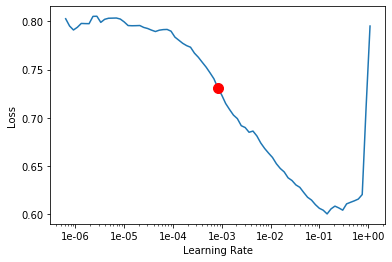

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr


epoch,train_loss,valid_loss,accuracy,time
0,0.717439,0.654837,0.721649,00:00
1,0.610177,0.564108,0.780069,00:00
2,0.562086,0.505281,0.780069,00:00


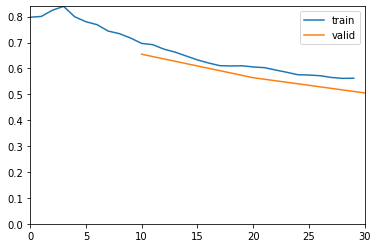

In [26]:
learn.fit_one_cycle(3, min_grad_lr) #We choose 3 cycles because over that the model began to overfit

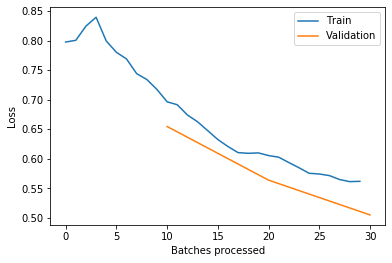

In [27]:
learn.model #~78% accuracy in almost no time!
learn.recorder.plot_losses()

In [28]:
learn.predict(df.iloc[0])

(Category 0, tensor(0), tensor([0.5586, 0.4414]))

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

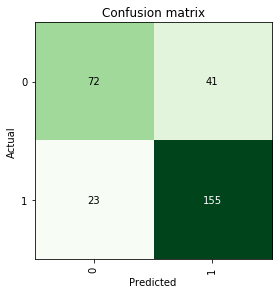

In [30]:
interp.plot_confusion_matrix(cmap='Greens')

In [31]:
#These are the ones it got SUPER wrong
interp.plot_tab_top_losses(10)

,Prediction,Actual,Loss,Probability,home_initial,vis_initial,ref1,ref2,ref3,off_perf_home_na,...,off_perf_vis,day_hour,score_bench_home,score_starter_vis,score_starter_home,frac_season,def_perf_vis,def_perf_home,attendance,perform
0,1,0,2.02,0.13,NOP,MIA,Boland,Kennedy,Williams,False,...,0.8641,0.1242,0.5804,-0.3569,1.6576,3.2231,1.2734,1.6395,0.3263,-1.1687
1,1,0,1.63,0.20,ATL,MEM,Guthrie,Kogut,Scott,False,...,0.3581,-0.1817,-0.5422,-0.6563,0.9101,3.0775,0.7394,1.5049,-0.7843,2.6621
2,1,0,1.54,0.21,NYK,UTA,#na#,Smith,Wright,False,...,1.5082,-0.1817,0.0483,0.8960,-1.1243,3.1503,0.0274,0.9661,-0.5899,-0.7156
3,1,0,1.53,0.22,NYK,WAS,Green,Kogut,Zarba,False,...,2.2902,-0.1817,0.1274,-0.2661,-0.9315,2.3858,2.8310,0.6967,0.5563,-0.2213
4,0,1,1.49,0.23,DET,MIL,Barnaky,Dalen,Mott,False,...,0.9101,-0.4876,0.8679,1.3448,-1.9168,2.6771,-0.7292,-0.9196,-0.8404,0.2318
5,1,0,1.48,0.23,DEN,MIL,Davis,Forte,Wood,False,...,0.0361,0.7359,-0.3786,-3.8629,0.6081,3.3323,1.1844,0.0232,1.0680,-0.7156
6,0,1,1.42,0.24,CLE,CHI,Adair,Blair,Kirkland,False,...,-1.0680,0.1242,-2.5518,-0.9181,0.3841,1.7306,-0.8182,0.8763,0.8609,0.4790
7,1,0,1.40,0.25,ATL,DAL,Collins,Mott,Myers,False,...,0.7721,-0.1817,-1.0881,-2.6582,0.8851,2.7499,-0.8182,1.6844,-0.3542,0.0671
8,0,1,1.38,0.25,IND,TOR,Boland,Jr.,Taylor,False,...,0.3121,0.1242,0.0758,1.6113,0.3189,2.2038,-1.2632,-0.4257,-0.3655,-0.5096
9,1,0,1.23,0.29,BRK,PHO,Fitzgerald,Lane,Wood,False,...,0.4501,-0.1817,-0.0916,-0.2252,-0.5213,2.0582,0.7394,0.0681,-1.4556,0.8909


In [131]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [11]                 341        True      
______________________________________________________________________
Embedding            [11]                 341        True      
______________________________________________________________________
Embedding            [17]                 1,105      True      
______________________________________________________________________
Embedding            [18]                 1,314      True      
______________________________________________________________________
Embedding            [16]                 1,024      True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
_________________________________________________